## Building the ML model
### Adding the usual imports and configurations

In [1]:
from pandas import read_csv, to_datetime, unique, DataFrame, to_numeric
from warnings import filterwarnings
from numpy import array
from IPython.display import display
from src.utils import *

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier, plot_importance, plot_tree
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

### Initial data preparation  
Reading the data and transforming some feature types

In [2]:
# Reading the filtered dataset
df = read_csv("./databases/cleaned_clients.csv")

# Checking that all features have a correct type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerId        10000 non-null  int64  
 1   Surname           10000 non-null  object 
 2   Geography         10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   HasCrCard         10000 non-null  float64
 5   IsActiveMember    10000 non-null  float64
 6   EstimatedSalary   10000 non-null  float64
 7   application_date  10000 non-null  object 
 8   exit_date         7183 non-null   object 
 9   birth_date        10000 non-null  object 
 10  age               10000 non-null  float64
 11  products          10000 non-null  int64  
 12  balance           10000 non-null  float64
 13  score             10000 non-null  float64
dtypes: float64(6), int64(2), object(6)
memory usage: 1.1+ MB


In [3]:
# Correcting the wrong types
df['application_date'] = to_datetime(df['application_date'])
df['exit_date'] = to_datetime(df['exit_date'])
df['birth_date'] = to_datetime(df['birth_date'])

The only feature that has null values is **exit_date**. How all other features are completed, it is not necessary to perform any other transformation.

In [4]:
# days between application_date and exit_date
df['c_days'] = (df['exit_date'] - df['application_date']).dt.days
df['churn'] = df['c_days'] <= 730
df.churn = df.churn.astype(int)

#df.to_csv(path_or_buf='./databases/df_for_R.csv', index=False)
df.head().T

,0,1,2,3,4
CustomerId,15610711,15764170,15594720,15706552,15785358
Surname,Eluemuno,Pinto,Scott,Odinakachukwu,Gresswell
Geography,Germany,Germany,Germany,France,Germany
Gender,Female,Male,Female,Male,Male
HasCrCard,0.0,1.0,1.0,0.0,1.0
IsActiveMember,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,167673.37,36579.53,189339.6,156731.91,79366.98
application_date,2017-03-05 00:00:00,2017-02-05 00:00:00,2017-11-08 00:00:00,2016-02-15 00:00:00,2016-09-17 00:00:00
exit_date,2019-11-27 00:00:00,2018-10-11 00:00:00,NaT,2019-10-02 00:00:00,2016-12-20 00:00:00
birth_date,1976-10-21 00:00:00,1972-04-02 00:00:00,1982-05-14 00:00:00,1979-09-09 00:00:00,1969-11-11 00:00:00


Let’s look at our target variable: **churn**. For binary classification, all models typically expect a number as 0 for don't leave the service before two years and 1 for leaving it before two years.

#### Splitting datasets

Now, we need to split our dataset into training, validation, and test sets.

In [5]:
# selected features
features = [
    "churn",
    "Gender",
    "Geography",
    "HasCrCard",
    "IsActiveMember",
    "EstimatedSalary",
    "age",
    "products",
    "balance",
    "score",
]

# test set
df_train_full, df_test = train_test_split(
    df[features], test_size=0.2, random_state=123
)

# train and validation sets
df_train, df_val = train_test_split(
    df_train_full, test_size=0.33, random_state=321
)

# target feature
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# delete the target feature to avoid confusions
del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

### Exploratory data analysis

Checking the distribution of values in the target variable. 

In [6]:
# distribution on percentages
df_train_full.churn.value_counts()/len(df_train_full)

0    0.798625
1    0.201375
Name: churn, dtype: float64

We can see that approximately 0.79% of customers stopped using the "Kin Safety" service within two years. 

We can separate categorical and numerical features to analyze it, so:

In [7]:
categorical = ["Gender", "Geography", "HasCrCard", "IsActiveMember"]
numerical = [
    "EstimatedSalary",
    "age",
    "products",
    "balance",
    "score",
]

# y_full = df_train_full.churn.values
# del df_train_full["churn"]

We can analize the unique values of categorical data:

In [8]:
df_train_full[categorical].nunique()

Gender            2
Geography         3
HasCrCard         2
IsActiveMember    2
dtype: int64

How the data have two or three values is not necessary to perform more transformations.

<!-- ### Reducing the model complexity -->

In [9]:
# no_churn_users = df_train_full[df_train_full['exit_date'] == 0]
# churn_users = df_train_full[df_train_full['exit_date'] == 1]

# df_train_full.exit_date.value_counts()

In [10]:
# mbk = MiniBatchKMeans(
#     init="k-means++",
#     n_clusters=200,
#     batch_size=45,
#     n_init=10,
#     max_no_improvement=10,
#     verbose=0,
#     random_state=555
# )

In [11]:
# # To use scikit-learn we need the data as dictionary
# clust_dict = churn_users[categorical + numerical].to_dict(orient='rows')

# dvc = DictVectorizer(sparse=False)
# dvc.fit(clust_dict)

# # Convert the dictionaries to a matrix
# X_clust = dvc.transform(clust_dict)

# model = make_pipeline(StandardScaler(), mbk)
# tic()
# model.fit(X_clust)
# toc()

# churn_users['clust'] = mbk.labels_

In [12]:
# clust_df = DataFrame(columns=churn_users.columns)
# samples_per_cluster = 15

# by_clust = churn_users.groupby('clust')

# for groups, data in by_clust:
#     samples = len(data)
#     if samples > samples_per_cluster:
#         clust_df = clust_df.append(data.sample(samples_per_cluster))
#     else:
#         clust_df = clust_df.append(data.sample(samples))
# clust_df.info()

In [13]:
# clust_df.products = to_numeric(clust_df.products)
# clust_df.exit_date = to_numeric(clust_df.exit_date)
# df_train_full = no_churn_users.append(clust_df)
# del df_train_full["clust"]

### Feature importance

To determine if a categorical feature influences the decision to leave the service before two years, we group the data according to the values of the categorical features. After that, we compare their means with the global mean. Let's remember that our classification feature (**churn**) is binary, so if we compute the mean result, it represents the percentage of customers that leave the service before two years.

#### Risk

To have a better idea of the influence of a feature, the computed mean will be compared with the **risk** (ratio between probabilities) based on the global_mean value (the total percentage of churn users).

In [14]:
global_mean = df_train_full.churn.mean()
print(f"The global mean is {global_mean}")

for feature in categorical: 
    df_group = df_train_full.groupby(by=feature).churn.agg(['mean']) 
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group) 

The global mean is 0.201375


,mean,risk
Gender,,
Female,0.247203,1.227577
Male,0.162630,0.807597


,mean,risk
Geography,,
France,0.158475,0.786967
Germany,0.319921,1.588685
Spain,0.165653,0.822612


,mean,risk
HasCrCard,,
0.0,0.205719,1.021573
1.0,0.199576,0.991065


,mean,risk
IsActiveMember,,
0.0,0.268942,1.335530
1.0,0.138156,0.686065


To use the risk, we need to remember that a group with a risk close to 1 is not risky at all (to leave the service).

With the previous results we discovered that:  
>- The values with less risk are Male, France, and Active members
>- The risks from **Gender**, **Geography**, and **IsActiveMember** show that these features can be very important in our final classification

#### Mutual Information

In this subsection, we will utilize mutual information to measure the mutual dependency between two variables (using the categorical features).

In [15]:
df_mi = df_train_full[categorical].apply(
    calculate_mi, 
    labels=df_train_full.churn
)

df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI') #D
df_mi

,MI
Geography,0.013939
IsActiveMember,0.013402
Gender,0.005505
HasCrCard,0.000024


We can conclude that the most important categorical features are **Geography** and **IsActiveMember** (similar as in the risk analysis).

#### Correlation coeficient

For numerical data, we will use the correlation coefficient to quantify the degree of dependency between features and the target label (if a clients leave the service).

In [16]:
df_train_full[numerical].corrwith(df_train_full.churn, method='spearman')

EstimatedSalary    0.010040
age                0.311728
products          -0.130914
balance            0.106240
score             -0.041139
dtype: float64

We can conclude that all features are not correlated with the target label.

<!-- ### Feature engineering -->

<!-- We are goint to use the one-hot encoding of the df_train as input of our model, so: -->

In [17]:
# # To use scikit-learn we need the data as dictionary
# # train_dict = df_train[categorical + numerical].to_dict(orient='rows')
# train_dict = df_train_full[categorical + numerical].to_dict(orient='rows')

# dv = DictVectorizer(sparse=False)
# dv.fit(train_dict)

# # Convert the dictionaries to a matrix
# X_train = dv.transform(train_dict)

# # Transfor the valitation data in a valid format to our model:
# val_dict = df_val[categorical + numerical].to_dict(orient='rows') 
# X_val = dv.transform(val_dict)

# # Show the names of the columns
# dv.get_feature_names()

### Train and evaluate the ML model
#### Training the complete model (with all features)
We use a Extreme Gradient Boosting (XGBoost) model because it is flexible, simple to implement, to train, and to use.

In [18]:
# define model
model = XGBClassifier(
    n_estimators=4000, 
    max_depth=30, 
    learning_rate=0.01,
    scale_pos_weight=99
)

X_t = one_hot_encoding(df_train[categorical + numerical])
X_v = one_hot_encoding(df_val[categorical + numerical])

# train the model
tic()
model.fit(X_t, y_train,
        eval_set=[(X_t, y_train), (X_v, y_val)],
        early_stopping_rounds=50,
        verbose=200
) 
toc()

[19:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68960	validation_1-logloss:0.69037
[200]	validation_0-logloss:0.34029	validation_1-logloss:0.52206
[400]	validation_0-logloss:0.18619	validation_1-logloss:0.51001
[475]	validation_0-logloss:0.14721	validation_1-logloss:0.50946
Elapsed time is 8.600000 seconds.


#### Complete Model Evaluation

Now we need to predict the values of our validation data:

In [19]:
X_test = one_hot_encoding(df_test[categorical + numerical])

# predictiong new values
y_pred = model.predict(X_test)

# Showing the Area under the ROC curve (AUC)
roc_auc_score(y_test, y_pred)

0.76945045964052

In [20]:
model.save_model('./models/XGB_model.json')

# model = XGBClassifier()
# model.load_model('./models/XGB_model.json')

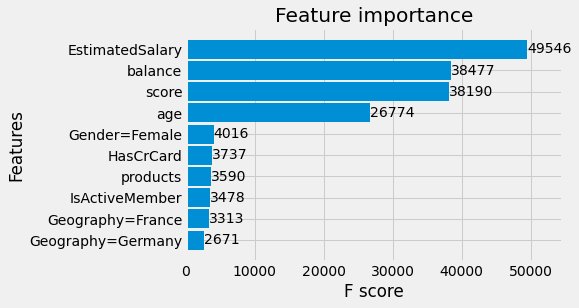

In [21]:
# showing the feature importance plot
plot_importance(model, height=0.9 ,max_num_features = 10)
plt.show()

#### Confidence interval of the model

To show how safe the model is when trained with the above parameters, we will perform a **k-Fold Cross-Validation** test.

In [22]:
kfold = KFold(n_splits=9, shuffle=True, random_state=888)

aucs = []

X_test = one_hot_encoding(df_test[categorical + numerical])

# define model
model = XGBClassifier(
    n_estimators=4000, 
    max_depth=30, 
    learning_rate=0.01,
    scale_pos_weight=99
)

for train_idx, val_idx in kfold.split(df_train_full): 
    df_train = df_train_full.iloc[train_idx] 
    df_val = df_train_full.iloc[val_idx] 
    
    y_train = df_train.churn.values 
    y_val = array(df_val.churn.values)
    
    del df_train['churn']
    del df_val['churn']
    
    X_t = one_hot_encoding(df_train[categorical + numerical])
    X_v = one_hot_encoding(df_val[categorical + numerical])
    
    # train the model
    tic()
    model.fit(X_t, y_train,
            eval_set=[(X_t, y_train), (X_v, y_val)],
            early_stopping_rounds=50,
            verbose=500
    ) 
    toc() 
    
    # predictiong new values
    y_pred = model.predict(X_test)

    # Area under the ROC curve (AUC)  
    auc = roc_auc_score(y_test, y_pred) 
    aucs.append(auc) 

aucs

[19:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68921	validation_1-logloss:0.69044
[500]	validation_0-logloss:0.13615	validation_1-logloss:0.48633
[639]	validation_0-logloss:0.08820	validation_1-logloss:0.48490
Elapsed time is 15.481006 seconds.
[19:45:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68933	validation_1-logloss:0.69019
[272]	validation_0-logloss:0.27266	validation_1-logloss:0.50260
Elapsed time is 6.086996 seco

[0.7676578317852903,
 0.768491508133937,
 0.7606364574571528,
 0.7588005798450168,
 0.7694877439137151,
 0.7686316970011514,
 0.770290101472878,
 0.7549349464001289,
 0.7763361192142265]

Finally, the 95% confidence interval is:

In [23]:
confidence_interval_t(aucs)

(0.7610120922245072, 0.7712694600473811)

<!-- #### Parameter tunning -->

In [24]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV

In [25]:
# # define model
# model2 = XGBClassifier(
#     n_estimators=3000, 
#     max_depth=20, 
#     learning_rate=0.01,
#     #scale_pos_weight=99
# )

# X_t = one_hot_encoding(df_train_full[categorical + numerical])

# # define grid
# weights = [10, 25, 50, 75, 99, 100]
# param_grid = dict(scale_pos_weight=weights)

# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=132)

# # define grid search
# grid = GridSearchCV(
#     estimator=model2, 
#     param_grid=param_grid, 
#     n_jobs=-1, 
#     cv=cv, 
#     scoring='roc_auc'
# )

# # execute the grid search
# tic()
# grid_result = grid.fit(X_t, y_full)
# toc()

# # report the best configuration
# print("Best: %f using %s" % 
#       (grid_result.best_score_, grid_result.best_params_)
#      )

# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [26]:
# X_test = one_hot_encoding(df_test[categorical + numerical])

# # predictiong new values
# y_pred = grid.predict(X_test)

# # Showing the Area under the ROC curve (AUC)
# roc_auc_score(y_test, y_pred)